In [16]:
import numpy
import torch
import matplotlib.pyplot as plt
import cv2
import supervision as sv
# import torchvision.transforms.functional as F
import numpy as np

from segment_anything import SamPredictor, sam_model_registry
from segment_anything import SamAutomaticMaskGenerator

device = torch.device('cuda:0')

In [17]:
class SegmentAnything:
    def __init__(self, device, model_type, sam_checkpoint):
        print("init Segment Anything")
        self.device = device
        self.sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        self.sam.to(self.device)

    def generat_masks(self, image):
        print("generate masks by Segment Anything")
        # 検出するマスクの品質　（default: 0.88)
        # pred_iou_thresh = 0.96 640*480の時ちょうどよかった
        pred_iou_thresh = 0.98  #  960×720の時はこれぐらい
        mask_generator_2 = SamAutomaticMaskGenerator(
            model=self.sam, pred_iou_thresh=pred_iou_thresh
        )
        masks = mask_generator_2.generate(image)
        self.sorted_anns = sorted(masks, key=(lambda x: x["area"]), reverse=True)
        self._length = len(masks)
        print("{} masks generated.".format(self._length))

    def generat_masks_all(self, image):
        print("generate masks by Segment Anything")
        # 検出するマスクの品質　（default: 0.88)
        # pred_iou_thresh = 0.96 640*480の時ちょうどよかった
        pred_iou_thresh = 0.98  #  960×720の時はこれぐらい
        mask_generator_2 = SamAutomaticMaskGenerator(
            model=self.sam, pred_iou_thresh=pred_iou_thresh
        )
        masks = mask_generator_2.generate(image)
        self.sorted_anns = sorted(masks, key=(lambda x: x["area"]), reverse=True)
        self._length = len(masks)
        print("{} masks generated.".format(self._length))
        return masks

    @property
    def length(self):
        return self._length

    def get(self, index):
        pixels = self.sorted_anns[index]["area"]
        mask = np.expand_dims(self.sorted_anns[index]["segmentation"], axis=-1)
        return mask, pixels

In [18]:
def read_image(file_name):
    image = cv2.imread(file_name)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]
    return image, height, width


In [109]:
image, height, width = read_image('image/fd400708.jpg')
# image = cv2.resize(image,(160,120))
# height, width = 120, 160


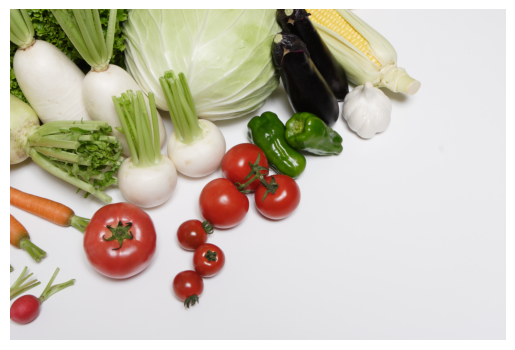

In [110]:
plt.imshow(image)
plt.axis("off")
plt.show()

In [111]:
#segment anything クラスを生成
sam = SegmentAnything(device, "vit_b", "../models/sam_vit_b_01ec64.pth")

init Segment Anything


In [112]:
# マスク生成
masks = sam.generat_masks_all(image)

generate masks by Segment Anything
15 masks generated.


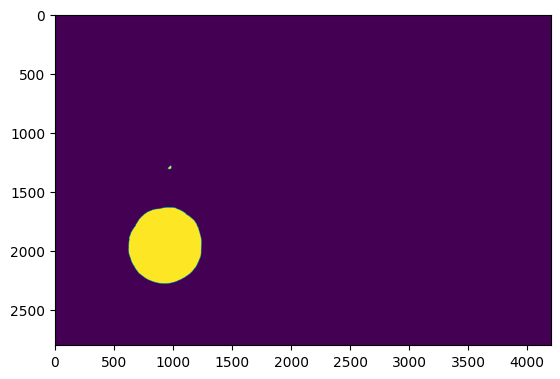

In [113]:
plt.imshow(masks[5]['segmentation'])

In [114]:
# エリアを検出するクラス
class Area:
    def __init__(self, width, height):
        self.x1 = width
        self.x2 = 0
        self.y1 = height
        self.y2 = 0

    def set(self, x, y):
        if x < self.x1:
            self.x1 = x
        if self.x2 < x:
            self.x2 = x
        if y < self.y1:
            self.y1 = y
        if self.y2 < y:
            self.y2 = y

    def get(self):
        return self.x1, self.y1, self.x2, self.y2

In [115]:
# print(sam.length)

In [120]:
data_list = []
    # 一定のサイズのものだけを抽出する
max_pixels = 10000000
min_pixels = 10
# pr
food_images = []
for index in range(sam.length):
    mask, pixels = sam.get(index)
    print('mask', mask.shape)
    print('pixels', pixels)

    # 一定範囲のサイズのみ対象にする
    if pixels < min_pixels or max_pixels < pixels:
        continue

    # 輪郭検出用の2値のテンポラリ画像
    mono_image = np.full(np.array([height, width, 1]), 255, dtype=np.uint8)
    # plt.imshow(mono_image)
    # plt.axis("off")
    # plt.show()
    # 個々の食品を切取るためのテンポラリ画像
    food_image = image.copy()
    area = Area(width, height)
    # print(width, height)
    for y in range(height):
        for x in range(width):
            # if y == 
            if mask[y][x]:
                mono_image[y][x] = 0  # ２値画像は、マスク部分を黒にする
                area.set(x, y)
            else:
                food_image[y][x] = [255, 255, 255]  # 食品切取り画像は、マスク部分以外を白にする

    # 検出範囲
    x1, y1, x2, y2 = area.get()
    # 食品の輪郭を取得する
    contours, _ = cv2.findContours(
        mono_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )
    # 食品画像を切取る
    food_images.append(food_image[y1:y2, x1:x2])
    # break

mask (2800, 4200, 1)
pixels 6141098
mask (2800, 4200, 1)
pixels 970973
mask (2800, 4200, 1)
pixels 314148
mask (2800, 4200, 1)
pixels 313865
mask (2800, 4200, 1)
pixels 311475
mask (2800, 4200, 1)
pixels 272140
mask (2800, 4200, 1)
pixels 152499
mask (2800, 4200, 1)
pixels 145184
mask (2800, 4200, 1)
pixels 143244
mask (2800, 4200, 1)
pixels 134591
mask (2800, 4200, 1)
pixels 101561
mask (2800, 4200, 1)
pixels 60354
mask (2800, 4200, 1)
pixels 58841
mask (2800, 4200, 1)
pixels 50794
mask (2800, 4200, 1)
pixels 49495


In [122]:
len(food_images)

15

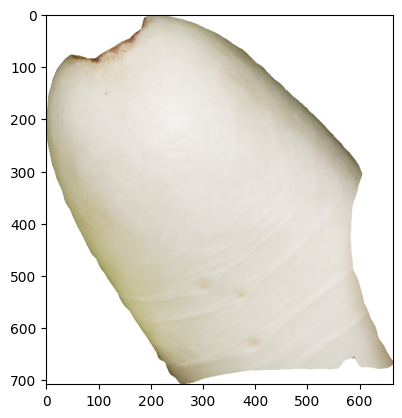

In [127]:
plt.imshow(food_images[4])

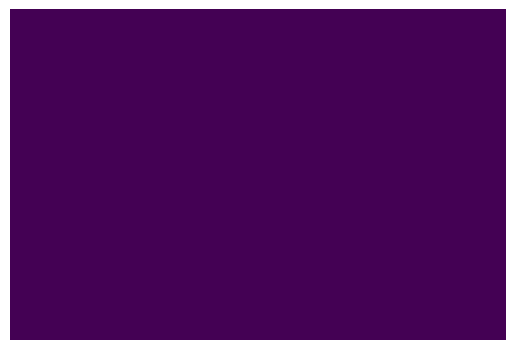

In [36]:
plt.imshow(mono_image)
plt.axis("off")
plt.show()